In [1]:
import sys
print(sys.executable)

C:\Users\user\anaconda3\envs\tf_gpu\python.exe


1.Initial Setup and Imports

In [2]:
# This cell contains all the necessary libraries and defines global parameters.

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large # Example models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import shutil # Added for Cell 2's data splitting logic
import random # Added for Cell 2's data splitting logic

# Define global parameters
IMG_HEIGHT = 224 # Standard input size for many pre-trained models
IMG_WIDTH = 224  # Standard input size for many pre-trained models
BATCH_SIZE = 128  # Number of images to process in each batch
NUM_EPOCHS = 50  # Number of training epochs
LEARNING_RATE = 0.0001 # Learning rate for the optimizer

# Base directory for your dataset
base_dir = r'C:\Users\user\Downloads\imagesaipro'

# Number of classes (cat breeds)
NUM_CLASSES = 19

# Ensure the base directory exists
os.makedirs(base_dir, exist_ok=True)

print(f"Base Directory: {base_dir}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Image Dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")

Base Directory: C:\Users\user\Downloads\imagesaipro
Number of Classes: 19
Image Dimensions: 224x224


2.Data Engineer - Data Splitting & Directory Setup

In [3]:
# This cell will now create the train, validation, and test splits from your raw data.

# Define paths for train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# List of 19 cat breed categories (folder names directly under base_dir)
categories = [
    'turkish_van', 'sphynx_cat', 'siamese_cat', 'scottish_fold', 'savannah_cat',
    'russian_blue', 'ragdoll_cat', 'persian_cat', 'oriental_shorthair', 'manx_cat',
    'maine_coon', 'devon_rex', 'chartreux', 'british_shorthair', 'birman_cat',
    'bengal_cat', 'balinese_cat', 'american_shorthair', 'abyssinian_cat'
]

# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

print("--- Data Engineer: Starting Data Splitting ---")
print(f"Split ratio: Train {train_ratio*100}%, Validation {val_ratio*100}%, Test {test_ratio*100}%")

# Create main train, validation, and test directories (and delete if they exist from prior runs)
# This ensures a clean slate before splitting
if os.path.exists(train_dir): shutil.rmtree(train_dir)
if os.path.exists(val_dir): shutil.rmtree(val_dir)
if os.path.exists(test_dir): shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

total_images_processed = 0

# Process each category
for category in categories:
    source_category_path = os.path.join(base_dir, category)
    
    # Ensure the source category folder exists
    if not os.path.exists(source_category_path):
        print(f"Warning: Source folder not found for '{category}' at '{source_category_path}'. Skipping.")
        continue
    
    # List all image files in the source category folder
    all_files = [f for f in os.listdir(source_category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp'))]
    if not all_files:
        print(f"Warning: No image files found in '{source_category_path}'. Skipping.")
        # If the folder is empty, delete it
        if os.path.exists(source_category_path):
            shutil.rmtree(source_category_path)
        continue

    random.shuffle(all_files) # Shuffle the files for random splitting

    num_files = len(all_files)
    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)
    num_test = num_files - num_train - num_val # Remaining files go to test

    print(f"\nProcessing '{category}': Found {num_files} images.")
    
    # Create destination subdirectories for the current category in train/val/test
    train_cat_dir = os.path.join(train_dir, category)
    val_cat_dir = os.path.join(val_dir, category)
    test_cat_dir = os.path.join(test_dir, category)

    os.makedirs(train_cat_dir, exist_ok=True)
    os.makedirs(val_cat_dir, exist_ok=True)
    os.makedirs(test_cat_dir, exist_ok=True)

    # Move files to their respective destination folders
    moved_train, moved_val, moved_test = 0, 0, 0
    for i, filename in enumerate(all_files):
        source_file_path = os.path.join(source_category_path, filename)
        
        try:
            if i < num_train:
                shutil.move(source_file_path, os.path.join(train_cat_dir, filename))
                moved_train += 1
            elif i < num_train + num_val:
                shutil.move(source_file_path, os.path.join(val_cat_dir, filename))
                moved_val += 1
            else:
                shutil.move(source_file_path, os.path.join(test_cat_dir, filename))
                moved_test += 1
        except Exception as e:
            print(f"Error moving file {source_file_path}: {e}")

    print(f"  Moved {moved_train} to train, {moved_val} to val, {moved_test} to test.")
    total_images_processed += (moved_train + moved_val + moved_test)

    # Clean up: Delete the original category folder from base_dir after moving all its images
    if os.path.exists(source_category_path):
        try:
            shutil.rmtree(source_category_path)
            print(f"  Cleaned up original folder: {source_category_path}")
        except Exception as e:
            print(f"Error deleting original folder {source_category_path}: {e}")


print("\n--- Data Splitting and Directory Setup Complete! ---")
print(f"Total images processed and split: {total_images_processed}")
print(f"Train data now in: {train_dir}")
print(f"Validation data now in: {val_dir}")
print(f"Test data now in: {test_dir}")

--- Data Engineer: Starting Data Splitting ---
Split ratio: Train 70.0%, Validation 15.0%, Test 15.0%

Processing 'turkish_van': Found 137 images.
  Moved 95 to train, 20 to val, 22 to test.
  Cleaned up original folder: C:\Users\user\Downloads\imagesaipro\turkish_van

Processing 'sphynx_cat': Found 263 images.
  Moved 184 to train, 39 to val, 40 to test.
  Cleaned up original folder: C:\Users\user\Downloads\imagesaipro\sphynx_cat

Processing 'siamese_cat': Found 232 images.
  Moved 162 to train, 34 to val, 36 to test.
  Cleaned up original folder: C:\Users\user\Downloads\imagesaipro\siamese_cat

Processing 'scottish_fold': Found 180 images.
  Moved 125 to train, 27 to val, 28 to test.
  Cleaned up original folder: C:\Users\user\Downloads\imagesaipro\scottish_fold

Processing 'savannah_cat': Found 139 images.
  Moved 97 to train, 20 to val, 22 to test.
  Cleaned up original folder: C:\Users\user\Downloads\imagesaipro\savannah_cat

Processing 'russian_blue': Found 139 images.
  Moved 97

3.Data Engineer - Data Preparation (Image Generators)

In [4]:
# This cell sets up ImageDataGenerators for training, validation, and testing.

# Data Augmentation and Rescaling for Training Data
# - shear_range, zoom_range, horizontal_flip: common augmentation techniques to prevent overfitting
# - rescale: normalize pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling for Validation and Test Data (no augmentation for consistent evaluation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches from the 'train_dir'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    shuffle=True
)

# Flow validation images in batches from the 'val_dir'
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

# Flow test images in batches from the 'test_dir'
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle test data
)

# Get the class labels in the order they are used by the generators
class_labels = list(train_generator.class_indices.keys())

print("\nImage Generators Setup Complete!")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")
print(f"Class Labels: {class_labels}")

Found 2393 images belonging to 19 classes.
Found 505 images belonging to 19 classes.
Found 531 images belonging to 19 classes.

Image Generators Setup Complete!
Found 2393 training images belonging to 19 classes.
Found 505 validation images belonging to 19 classes.
Found 531 test images belonging to 19 classes.
Class Labels: ['abyssinian_cat', 'american_shorthair', 'balinese_cat', 'bengal_cat', 'birman_cat', 'british_shorthair', 'chartreux', 'devon_rex', 'maine_coon', 'manx_cat', 'oriental_shorthair', 'persian_cat', 'ragdoll_cat', 'russian_blue', 'savannah_cat', 'scottish_fold', 'siamese_cat', 'sphynx_cat', 'turkish_van']


4.Data Scientist - Model Architecture (Transfer Learning)

In [5]:
# This cell defines functions to build models using pre-trained CNNs.

def build_model(base_model_name="ResNet50"):
    """
    Builds a transfer learning model using a specified pre-trained CNN.
    
    Args:
        base_model_name (str): Name of the pre-trained model ('ResNet50', 'DenseNet121', 'MobileNetV3Large').
    
    Returns:
        tf.keras.Model: Compiled Keras model.
    """
    if base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == "MobileNetV3Large":
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:
        raise ValueError("Invalid base_model_name. Choose from 'ResNet50', 'DenseNet121', 'MobileNetV3Large'.")

    # Freeze the layers of the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions, suitable for classification
    x = Dense(1024, activation='relu')(x) # A fully connected layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Output layer for multi-class classification

    # Combine base model with custom layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
                  metrics=['accuracy'])

    print(f"\nModel built: {base_model_name}")
    model.summary()
    return model

print("Model architecture functions defined.")

Model architecture functions defined.


5.Data Scientist - Model Training

In [6]:
# This cell trains the specified model and saves its history.
import time # Import time module for tracking training time
import os # Import os module for cpu_count
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Make sure these are imported if they aren't globally

def train_model(model, model_name):
    """
    Trains the given Keras model.
    
    Args:
        model (tf.keras.Model): The compiled Keras model to train.
        model_name (str): Name of the model for saving checkpoints.
        
    Returns:
        tf.keras.callbacks.History: Training history object.
    """
    # Define callbacks for training
    checkpoint_filepath = f'best_model_{model_name}.weights.h5' 
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )


    reduce_lr_on_plateau_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )

    callbacks = [model_checkpoint_callback, reduce_lr_on_plateau_callback]

    print(f"\n--- Training {model_name} Model ---")
    start_time = time.time() # Record start time

    history = model.fit(
        train_generator,
        epochs=NUM_EPOCHS, 
        validation_data=val_generator,
        callbacks=callbacks,
        workers=os.cpu_count() - 1, # Keep workers to use multiple threads for data loading
        use_multiprocessing=False # <<< CRITICAL CHANGE: Set to False to avoid pickling error
    )

    end_time = time.time() # Record end time
    training_time = end_time - start_time
    print(f"\n--- Training of {model_name} completed in {training_time:.2f} seconds ---")
    
    # Load the best weights found during training
    model.load_weights(checkpoint_filepath)
    
    return history, training_time

print("Model training function defined.")

Model training function defined.


6.Data Scientist - Train Models (Execution)

In [7]:
# This cell orchestrates the building and training of each specified model.

# IMPORTANT: Wrap the training loop in 'if __name__ == "__main__":'
# This is crucial for multiprocessing (workers > 0) with Keras on Windows
if __name__ == "__main__":
    models = {}
    histories = {}
    training_times = {}

    # List of models to train
    model_names_to_train = ["ResNet50", "DenseNet121", "MobileNetV3Large"] # Corrected to MobileNetV3Large

    for name in model_names_to_train:
        print(f"\n--- Building and Training {name} ---")
        model = build_model(name) # Calls the build_model function (from Cell 4)
        
        # Pass model and name to train_model function (from Cell 5)
        history, train_time = train_model(model, name) 
        
        models[name] = model
        histories[name] = history
        training_times[name] = train_time
        print(f"\n{name} training completed and best weights loaded.")

    print("\nAll models trained and best weights loaded.")


--- Building and Training ResNet50 ---

Model built: ResNet50
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________

7.Data Analyst - Data Visualization (Training Performance)

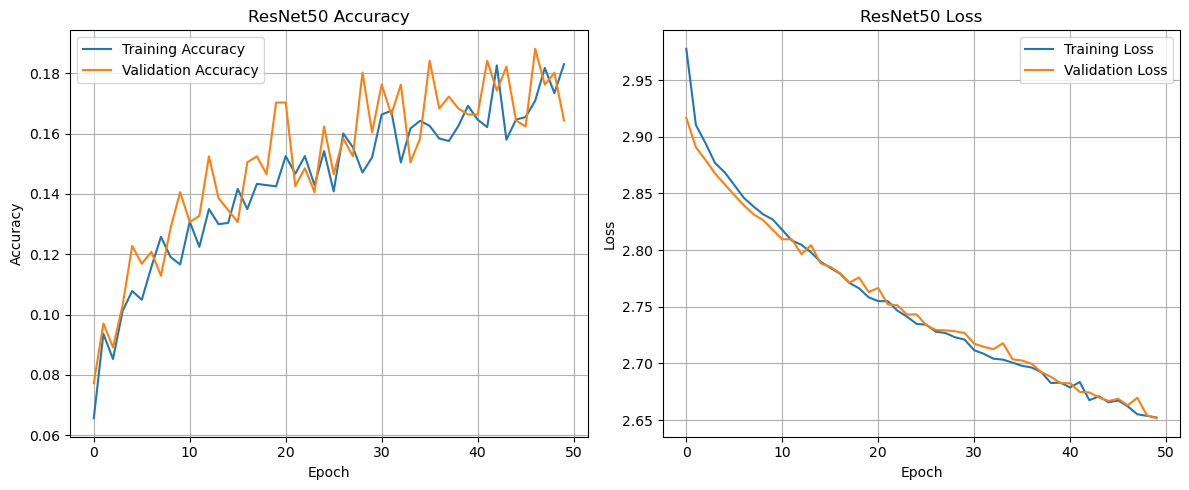

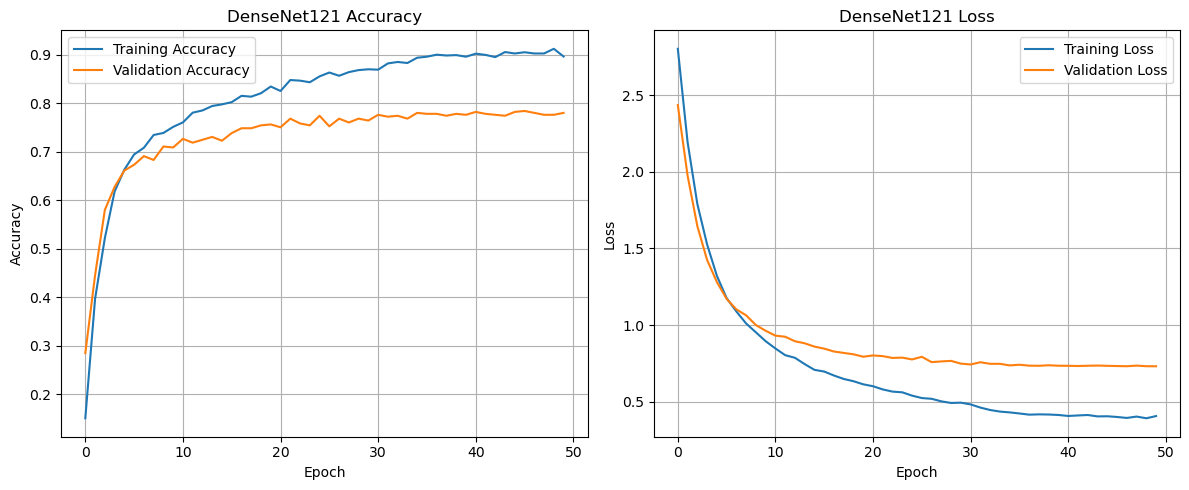

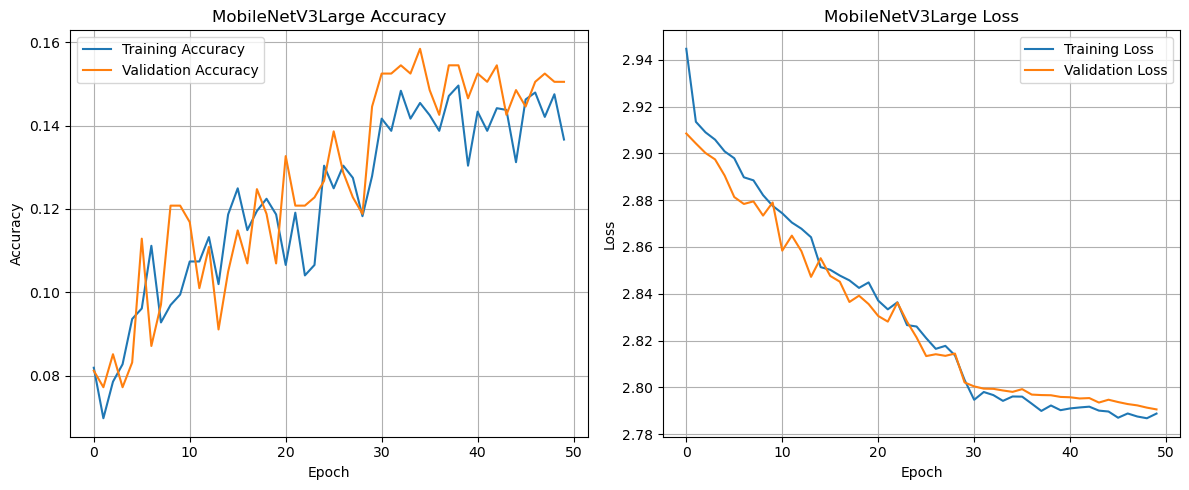

Training performance plots generated.


In [8]:
# This cell visualizes the training and validation accuracy and loss for each model.

def plot_training_history(history, model_name):
    """
    Plots the training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Generate plots for each model
for name, history in histories.items():
    plot_training_history(history, name)

print("Training performance plots generated.")

8.Data Analyst - Model Evaluation & Conclusion


--- Data Analyst: Model Evaluation ---

Evaluating ResNet50 on the test dataset...
5/5 [==============================] - 79s 14s/step - loss: 2.6717 - accuracy: 0.1751
  Test Loss: 2.6717
  Test Accuracy: 0.1751
  Evaluation Time: 102.61 seconds

Generating predictions for ResNet50...

Confusion Matrix for ResNet50:


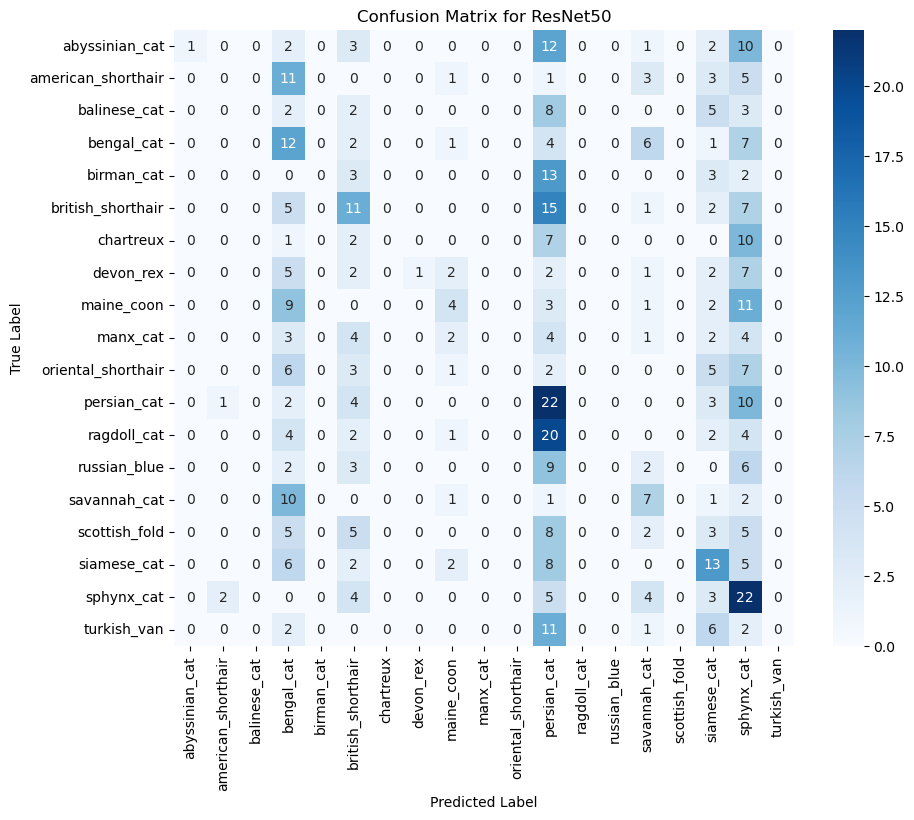


Classification Report for ResNet50:
                    precision    recall  f1-score   support

    abyssinian_cat       1.00      0.03      0.06        31
american_shorthair       0.00      0.00      0.00        24
      balinese_cat       0.00      0.00      0.00        20
        bengal_cat       0.14      0.36      0.20        33
        birman_cat       0.00      0.00      0.00        21
 british_shorthair       0.21      0.27      0.24        41
         chartreux       0.00      0.00      0.00        20
         devon_rex       1.00      0.05      0.09        22
        maine_coon       0.27      0.13      0.18        30
          manx_cat       0.00      0.00      0.00        20
oriental_shorthair       0.00      0.00      0.00        24
       persian_cat       0.14      0.52      0.22        42
       ragdoll_cat       0.00      0.00      0.00        33
      russian_blue       0.00      0.00      0.00        22
      savannah_cat       0.23      0.32      0.27        22
  

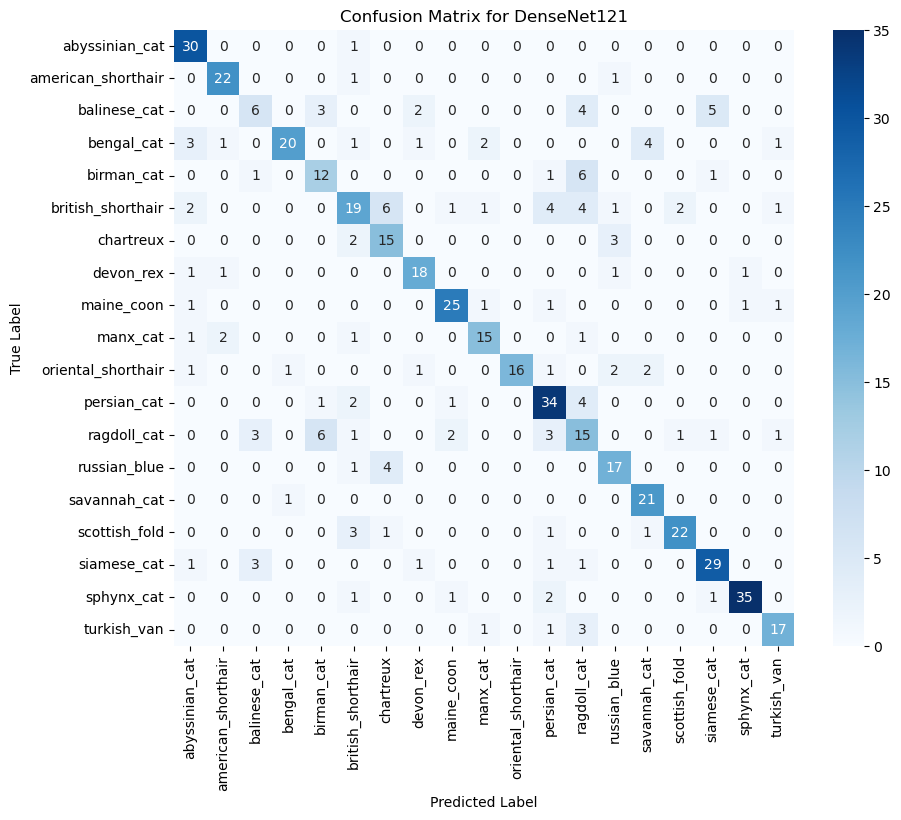


Classification Report for DenseNet121:
                    precision    recall  f1-score   support

    abyssinian_cat       0.75      0.97      0.85        31
american_shorthair       0.85      0.92      0.88        24
      balinese_cat       0.46      0.30      0.36        20
        bengal_cat       0.91      0.61      0.73        33
        birman_cat       0.55      0.57      0.56        21
 british_shorthair       0.58      0.46      0.51        41
         chartreux       0.58      0.75      0.65        20
         devon_rex       0.78      0.82      0.80        22
        maine_coon       0.83      0.83      0.83        30
          manx_cat       0.75      0.75      0.75        20
oriental_shorthair       1.00      0.67      0.80        24
       persian_cat       0.69      0.81      0.75        42
       ragdoll_cat       0.39      0.45      0.42        33
      russian_blue       0.68      0.77      0.72        22
      savannah_cat       0.75      0.95      0.84        22

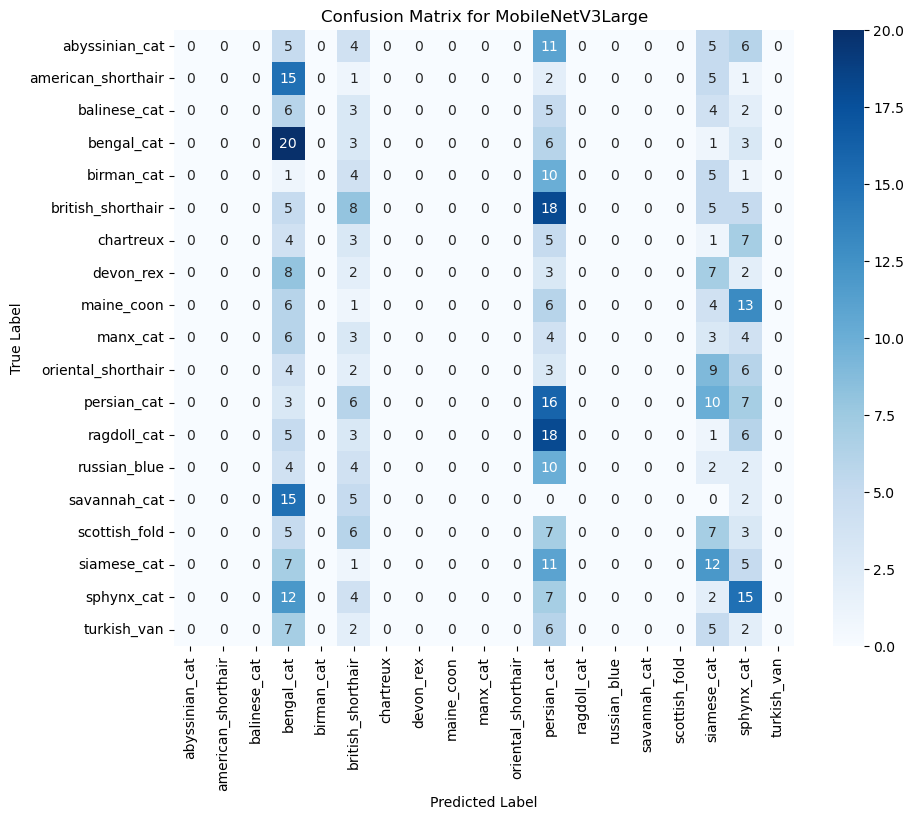


Classification Report for MobileNetV3Large:
                    precision    recall  f1-score   support

    abyssinian_cat       0.00      0.00      0.00        31
american_shorthair       0.00      0.00      0.00        24
      balinese_cat       0.00      0.00      0.00        20
        bengal_cat       0.14      0.61      0.23        33
        birman_cat       0.00      0.00      0.00        21
 british_shorthair       0.12      0.20      0.15        41
         chartreux       0.00      0.00      0.00        20
         devon_rex       0.00      0.00      0.00        22
        maine_coon       0.00      0.00      0.00        30
          manx_cat       0.00      0.00      0.00        20
oriental_shorthair       0.00      0.00      0.00        24
       persian_cat       0.11      0.38      0.17        42
       ragdoll_cat       0.00      0.00      0.00        33
      russian_blue       0.00      0.00      0.00        22
      savannah_cat       0.00      0.00      0.00     

In [10]:
# --- This cell evaluates the models on the test dataset and displays results.
import time # Ensure time is imported for recording evaluation time
import numpy as np # Ensure numpy is imported for numerical operations
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score # Add average_precision_score

print("\n--- Data Analyst: Model Evaluation ---")

# Store evaluation results for comparison
evaluation_results = {}

# Ensure class_labels is accessible (e.g., defined in Cell 3)
# Assuming class_labels = list(train_generator.class_indices.keys()) from your setup

for name, model in models.items():
    print(f"\nEvaluating {name} on the test dataset...")
    
    start_eval_time = time.time()
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    end_eval_time = time.time()
    eval_time = end_eval_time - start_eval_time
    
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Evaluation Time: {eval_time:.2f} seconds")

    # Generate Confusion Matrix and Classification Report
    print(f"\nGenerating predictions for {name}...")
    # Get true labels
    test_labels_true = test_generator.classes
    # Get predicted labels (as probabilities)
    test_predictions_probs = model.predict(test_generator)
    # Convert probabilities to class indices
    test_predictions_classes = np.argmax(test_predictions_probs, axis=1)

    print(f"\nConfusion Matrix for {name}:")
    cm = confusion_matrix(test_labels_true, test_predictions_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    print(f"\nClassification Report for {name}:")
    report = classification_report(test_labels_true, test_predictions_classes, target_names=class_labels, zero_division=0)
    print(report)

    # --- mAP Calculation ---
    print(f"\nCalculating mAP for {name}...")
    num_classes = len(class_labels)
    average_precisions = []

    for i in range(num_classes):
        # Create binary true labels for the current class
        y_true_class_i = (test_labels_true == i).astype(int)
        # Get prediction probabilities for the current class
        y_score_class_i = test_predictions_probs[:, i]
        
        # Handle cases where a class might not be present in true labels or predictions
        if np.sum(y_true_class_i) > 0 and len(np.unique(y_true_class_i)) > 1:
            ap_class_i = average_precision_score(y_true_class_i, y_score_class_i)
            average_precisions.append(ap_class_i)
        else:
            # If class not present or only one unique label, AP is undefined or 0.
            # We can append 0 or skip, depending on exact definition. Let's append 0 for average.
            average_precisions.append(0.0) 

    if average_precisions:
        mean_average_precision = np.mean(average_precisions)
    else:
        mean_average_precision = 0.0 # Should not happen if classes are present

    print(f"  Mean Average Precision (mAP): {mean_average_precision:.4f}")
    
    evaluation_results[name] = {
        'Test Loss': test_loss,
        'Test Accuracy': test_accuracy,
        'Training Time': training_times[name],
        'Evaluation Time': eval_time,
        'mAP': mean_average_precision # Add mAP to results
    }

print("\n--- Final Conclusion ---")
# Display summarized results for comparison
print("\nSummary of Model Performance:")
print("-------------------------------------------------------------------------------------------------------")
# Update header to include mAP
print(f"{'Model':<20} | {'Test Accuracy':<15} | {'Test Loss':<12} | {'Training Time (s)':<18} | {'Evaluation Time (s)':<18} | {'mAP':<10}")
print("-------------------------------------------------------------------------------------------------------")
for name, results in evaluation_results.items():
    # Update print format to include mAP
    print(f"{name:<20} | {results['Test Accuracy']:.4f}{'':<11} | {results['Test Loss']:.4f}{'':<7} | {results['Training Time']:.2f}{'':<14} | {results['Evaluation Time']:.2f}{'':<14} | {results['mAP']:.4f}")
print("-------------------------------------------------------------------------------------------------------")